# Reading in a large netCDF array and performing some simple calculations on it through Zarr

First, let's load in our modules

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import os
import dask.array as da
from time import sleep

We'll call in dask and create a local client with 10 workers that each has 4 threads.

We'll also print our dashboard link to view the progress of our dask job.

In [2]:
import dask
from distributed import Client

dask.config.set({'distributed.dashboard.link':'https://jupyter.alcf.anl.gov/theta/user/{USER}/proxy/{port}/status'})


client = Client(n_workers=10,threads_per_worker=4)

print(client.dashboard_link)

https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status,
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status,Workers: 10
Total threads: 40,Total memory: 503.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43845,Workers: 10
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/8787/status,Total threads: 40
Started: Just now,Total memory: 503.60 GiB
Comm: tcp://127.0.0.1:41234,Total threads: 4
Dashboard: https://jupyter.alcf.anl.gov/theta/user/bwallace/proxy/39847/status,Memory: 50.36 GiB
Nanny: tcp://127.0.0.1:43564,


Next, we'll pull in our files. In this case, we're going to be reading in 15-minute hourly accumulated precipitation across a 15 year period for a 4-km domain that encompasses the entirety of the CONUS.

We're also going to get rid of several files ahead of time that don't have a fully completed Time dimension. This doens't play nicely with uniform dimensions and throws off the chunking. So, any file that doesn't have 96 entries in Time (15 minute interval * 24 hours) will not be considered in our calculation.

In [4]:
from glob import glob

In [5]:
scenario='historical'

paths=np.array(glob('/eagle/climate_severe/Derived_Subsets/AFWA_TOTPRECIP/'+scenario+'/AFWA*'))
paths=np.sort(paths)

keywords_to_get_rid_of=['1998-09-28','2001-09-29','09-30','10-01']
for keyword in keywords_to_get_rid_of:
    paths=paths[np.array([keyword not in path for path in paths])]

The data is written to disk daily. We can see that across our full period, there are 5,442 days with full 15-minute interval data for us to read.

In [6]:
len(paths)

5442

We can pull this data in briefly and learn some more info about it's size and how it's chunked. 

The entirety of this dataset is a whopping 2.6 TB and it's chunked frequently in Time but not chunked at all in space. This orientation can be useful in situations where we want to create a time series. This approach typically involves taking the average in space across each time. 

However, if we want to take the average of all times and plot a map, we run into problems. Since an average needs to consider all available data in the Time dimension, and since space is not chunked it all, we can run into situations where our entire dataset is being pulled into memory and crashing the script.

In [7]:
with xr.open_mfdataset(paths) as f:
    total_filesize=f.nbytes/1e9
    print('Total filesize (gb): ',total_filesize)
    [print('Nchunks: ',len(f.chunksizes[key]),key) for key in f.chunksizes]

Total filesize (gb):  2628.257174784
Nchunks:  5442 Time
Nchunks:  1 south_north
Nchunks:  1 west_east


So it stands that if Time is continuous (not chunked) and we chunk frequently in space, then calculating the mean would require pulling in all available Times for smaller spatial chunks. This eases the burden on individual workers when distributing these chunks. The schematic below can help to illustrate this

<img src="img/chunking.png" alt="Chunking strategy"/>

If we wanted to take a mean across the Z dimension based on the chunking strategy in the middle, it would require loading in every point in the X and Y dimensions or 16 total points. For the chunking strategy on the right, taking the mean of the z dimension could be broken down by chunk, where you're only considering a chunk of 4 cells across all of their values in the z dimension. This reduces your total memory usage by a factor of 4 and highlights the need for effective chunking!

### What's the best method to go about rechunking a 2.6 TB dataset?

This is tricky. Xarray's open_mfdataset() call allows you to specify chunks when opening data. However, these chunks cannot be larger than the incoming file interval. So if you're loading in daily files each with 96 individual 15-minute readings, you're chunk in the time dimension cannot be larger than 96. 

You can rechunk a dataset after it's been loaded in as an mfdataset(), but this practice (especially on larger datasets) is not recommended by dask and either creates a larger number of tasks and bogs down the task scheduler, or it uses too much memory.

### The solution: Intermediate Zarr Chunking

We can get around this by loading in the entire dataset in pieces, and saving each piece as an individual Zarr array. Then, loading in all of the Zarr arrays, and rechunking them to be continuous in time. The reason why we're doing this intermediate step first is that it doesn't overload the dask task scheduler with too many tasks. Going from chunks of 96 in time to chunks of 96 * 365 days * 15 years creates too much overhead.

We'll specify our intervals in 100 GB chunks. Our dataset is 2.6 TB, so this will result in a little over 26 total Zarr arrays.

In [8]:
file_step=round(len(paths)/(total_filesize/100),0)

interval=np.arange(0,len(paths),int(file_step))
for i,start in enumerate(interval):
    if i<len(interval)-1:
        print(start,interval[i+1])
    else:
        print(start,'Until end')

0 207
207 414
414 621
621 828
828 1035
1035 1242
1242 1449
1449 1656
1656 1863
1863 2070
2070 2277
2277 2484
2484 2691
2691 2898
2898 3105
3105 3312
3312 3519
3519 3726
3726 3933
3933 4140
4140 4347
4347 4554
4554 4761
4761 4968
4968 5175
5175 5382
5382 Until end


As we can see, our initial estimate was correct. We're splitting our 2.6 TB array in 27 individual Zarr arrays.

In [9]:
len(interval)

27

We'll call in the rechunker module to do all of our heavy lifting for the rechunking. Rechunker utilizes an algorithm called push-pull-consolidated that is optimized for breaking up chunks and putting them back together into whatever orientation you want. However, it is limited by overhead when trying to chunk incredibly large datasets, so we'll first run it on each of our individual Zarr arrays.

In [10]:
from rechunker import rechunk

### Intermediate rechunking

Now we'll just loop through each interval and load in the dataset in 100 GB amounts at a time. Once loaded in, we'll specify that we want to new chunksize to span the entire time dimension and 100 gridpoints in both the x and y directions.

These chunks come in at ~100-500 MB in size and so we'll set our MAX_MEMORY to about 1 GB. Finally, we'll execute the process, restart our dask client to throw out any lingering data in memory once finished, and loop back to the next 100 GB set of files.

In [11]:
cell_start_time=datetime.now()

for i,start in enumerate(interval):
    if i<len(interval)-1:
        print(start,interval[i+1])
        start_pos=start
        end_pos=interval[i+1]
    else:
        print(start,'Until end')
        start_pos=start
        end_pos=None

    mfds=xr.open_mfdataset(paths[start_pos:end_pos],combine='nested',concat_dim='Time')

    target_chunks={
        'AFWA_TOTPRECIP':{'Time':len(mfds.Time),'south_north':100,'west_east':100},
        'Time': None,
    }

    target_store='/eagle/climate_severe/bwallace_scratch/temp/target_'+str(i).zfill(2)+'.zarr'
    temp_store='/eagle/climate_severe/bwallace_scratch/temp/tmp_'+str(i).zfill(2)+'.zarr'

    max_mem='1GB'

    array_plan=rechunk(mfds,target_chunks,max_mem,target_store,temp_store=temp_store)

    array_plan.execute()
    
    #clear some memory out between loops - not needed but want to see if
    #this can supress some of the garbage collection warnings
    sleep(2)
    client.restart()
    sleep(5)

0 207


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 1.78 MiB detected in task graph: 
  ("('copy_read_to_intermediate-04891f250e1d7d459316 ... ed71', 12268)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:22:33,200 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:22:33,203 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:22:33,207 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:22:33,211 - 

207 414


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:25:40,472 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,498 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,501 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,509 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,515 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,538 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,541 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,547 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,559 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:25:40,610 - distributed.nanny - WARNING - Restarting worker


414 621


2023-02-08 20:28:56,516 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,561 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,571 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,578 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,585 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,608 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,610 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,625 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,633 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:28:56,650 - distributed.nanny - WARNING - Restarting worker


621 828


Exception in thread Profile:
Traceback (most recent call last):
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/distributed/profile.py", line 343, in _watch
    process(frame, None, recent, omit=omit)
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/distributed/profile.py", line 168, in process
    new_state = process(prev, frame, state, stop=stop, depth=depth - 1)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/distributed/profile.py", line 173, in process
    ident = identifier(frame)
            ^^^^^^^^^^^^^^^^^
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/distribu

828 1035


2023-02-08 20:35:17,395 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,426 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,433 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,441 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,448 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,485 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,495 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,497 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,503 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:35:17,512 - distributed.nanny - WARNING - Restarting worker


1035 1242


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:38:42,225 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:38:42,282 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:38:42,295 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:38:42,296 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:38:42,301 - distributed.nan

1242 1449


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:41:59,870 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:41:59,872 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:41:59,896 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:41:59,897 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:41:59,900 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:41:59,904 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:41:59,910 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:41:59,925 - distributed.na

1449 1656


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:45:20,262 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,266 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,298 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,308 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,310 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,313 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,329 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,335 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,355 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:45:20,407 - distributed.nanny - WARNING - Restarting worker


1656 1863


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:48:41,005 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,008 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,012 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,016 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,026 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,027 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,047 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,085 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,091 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:48:41,188 - distributed.nanny - WARNING - Restarting worker


1863 2070


2023-02-08 20:52:02,617 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,646 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,657 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,679 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,681 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,731 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,743 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,753 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,762 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:52:02,769 - distributed.nanny - WARNING - Restarting worker


2070 2277


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:55:30,513 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:55:30,533 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:55:30,541 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:55:30,559 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:55:30,562 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:55:30,574 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:55:30,583 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:55:30,586 - distributed.na

2277 2484


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 20:59:00,287 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:59:00,389 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:59:00,409 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:59:00,416 - distributed.nanny - WARNING - Restarting worker
2023-02-08 20:59:00,429 - distributed.nan

2484 2691


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 21:02:21,951 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:21,955 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:21,965 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:21,974 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:21,983 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:21,985 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:22,001 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:22,060 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:22,071 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:02:22,167 - distributed.nanny - WARNING - Restarting worker


2691 2898


2023-02-08 21:05:47,902 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:47,914 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:47,966 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:47,978 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:47,985 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:47,986 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:47,997 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:47,999 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:48,002 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:05:48,021 - distributed.nanny - WARNING - Restarting worker


2898 3105


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
Exception in thread Profile:
Traceback (most recent call last):
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/home/bwallace/.conda/envs/geo_env/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bwal

3105 3312


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 21:12:33,145 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,150 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,169 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,179 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,196 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,204 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,229 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,275 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,281 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:12:33,288 - distributed.nanny - WARNING - Restarting worker


3312 3519


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 21:16:04,213 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:16:04,228 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:16:04,241 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:16:04,267 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:16:04,276 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:16:04,283 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:16:04,286 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:16:04,296 - distributed.na

3519 3726


2023-02-08 21:19:26,892 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,904 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,911 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,918 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,926 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,940 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,948 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,951 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:26,962 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:19:27,020 - distributed.nanny - WARNING - Restarting worker


3726 3933


2023-02-08 21:23:00,294 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,303 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,362 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,373 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,384 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,386 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,392 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,428 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,442 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:23:00,469 - distributed.nanny - WARNING - Restarting worker


3933 4140


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 21:26:28,230 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:26:28,282 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:26:28,289 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:26:28,310 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:26:28,312 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:26:28,318 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:26:28,324 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:26:28,334 - distributed.na

4140 4347


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 21:29:50,989 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:29:51,009 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:29:51,022 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:29:51,024 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:29:51,037 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:29:51,038 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:29:51,043 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:29:51,053 - distributed.na

4347 4554


2023-02-08 21:33:29,624 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,678 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,695 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,710 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,712 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,720 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,727 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,733 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,736 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:33:29,747 - distributed.nanny - WARNING - Restarting worker


4554 4761


/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/dask/base.py:1373: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(
2023-02-08 21:36:52,756 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,775 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,795 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,806 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,808 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,820 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,827 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,829 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,852 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:36:52,860 - distributed.nanny - WARNING - Restarting worker


4761 4968


2023-02-08 21:40:34,586 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,614 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,616 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,621 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,625 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,629 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,635 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,641 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,646 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:40:34,662 - distributed.nanny - WARNING - Restarting worker


4968 5175


2023-02-08 21:43:59,886 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:43:59,994 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,003 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,017 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,018 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,026 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,032 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,034 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,068 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:44:00,108 - distributed.nanny - WARNING - Restarting worker


5175 5382


2023-02-08 21:47:17,712 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,732 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,734 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,750 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,761 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,781 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,815 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,817 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,826 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:47:17,888 - distributed.nanny - WARNING - Restarting worker


5382 Until end


2023-02-08 21:48:10,372 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,390 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,398 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,425 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,439 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,443 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,451 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,462 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,469 - distributed.nanny - WARNING - Restarting worker
2023-02-08 21:48:10,515 - distributed.nanny - WARNING - Restarting worker


# Overall, this process took about 90 minutes. Which is pretty good.

In [12]:
print(datetime.now()-cell_start_time)

1:27:30.564987


We'll next open in all of our created Zarr files as one large dataset. This can easily be accomplished using xarray's open_mfdataset() and setting engine='zarr'.

In [3]:
big_zarr=xr.open_mfdataset('/eagle/climate_severe/bwallace_scratch/temp/target*.zarr',engine='zarr')

/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/xarray/backends/api.py:998: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/xarray/backends/api.py:998: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata 

/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/xarray/backends/api.py:998: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datasets = [open_(p, **open_kwargs) for p in paths]
/home/bwallace/.conda/envs/geo_env/lib/python3.11/site-packages/xarray/backends/api.py:998: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata 

### Characteristics of the Big ZARR

We can look a bit closer at our huge Zarr file to gain some insight into how our intermediate chunking faired. We can see that the total time dimension is 522,432 long, while our chunks are 19,872. Our ultimate goal is to rechunk so that there are no chunks in time, or that one chunk has a size of 522,432 in Time. 

We'll use rechunker again on this big Zarr to accomplish this.

In [14]:
big_zarr

<xarray.Dataset>
Dimensions:         (Time: 522432, south_north: 899, west_east: 1399)
Coordinates:
  * Time            (Time) datetime64[ns] 1990-10-02 ... 2005-09-29T23:45:00
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (Time, south_north, west_east) float32 dask.array<chunksize=(19872, 100, 100), meta=np.ndarray>
Attributes: (12/87)
    AERCU_FCT:                       1.0
    AERCU_OPT:                       0
    AUTO_LEVELS_OPT:                 2
    BL_PBL_PHYSICS:                  6
    BOTTOM-TOP_GRID_DIMENSION:       51
    BOTTOM-TOP_PATCH_END_STAG:       51
    ...                              ...
    WEST-EAST_GRID_DIMENSION:        1400
    WEST-EAST_PATCH_END_STAG:        1400
    WEST-EAST_PATCH_END_UNSTAG:      1399
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    history:                         Tue Sep  8 08:09:16 2020: ncks -O -x -v ...

# Rechunking the big Zarr

Now we just use the same method as above on this new file. We'll reduce the chunking in the x & y dimensions to account for the larger time dimension and try to keep our chunks from getting too large.

In [16]:
cell_start_time=datetime.now()

target_chunks={
    'AFWA_TOTPRECIP':{'Time':len(big_zarr.Time),'south_north':20,'west_east':20},
    'Time': None,
}

target_store='/eagle/climate_severe/bwallace_scratch/temp/big_rechunk.zarr'
temp_store='/eagle/climate_severe/bwallace_scratch/temp/tmp_big_rechunk.zarr'

max_mem='1.5GB'

array_plan=rechunk(big_zarr,target_chunks,max_mem,target_store,temp_store=temp_store)

array_plan.execute()

<zarr.hierarchy.Group '/'>

As we can see, this final rechunking step took about another 90 minutes. 

So overall, we spent 3 hours rechunking a 2.6 TB array into one that is continuous in time. The total size of this Zarr array on disk is also a fairly impressive 289 GB.  Roughly 10% the size of our total array, highlighting the impressive compressibility of Zarr arrays.

In [17]:
print(datetime.now()-cell_start_time)

1:38:37.181000


We'll load in our final processed Zarr file, and we can see that there are zero chunks in Time, meaning that this new dataset is optimized for calculations along the Time dimension.

In [3]:
final_zarr=xr.open_zarr('/eagle/climate_severe/bwallace_scratch/temp/big_rechunk.zarr')

/tmp/ipykernel_33082/2234163443.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  final_zarr=xr.open_zarr('/eagle/climate_severe/bwallace_scratch/temp/big_rechunk.zarr')


In [4]:
final_zarr

<xarray.Dataset>
Dimensions:         (Time: 522432, south_north: 899, west_east: 1399)
Coordinates:
  * Time            (Time) datetime64[ns] 1990-10-02 ... 2005-09-29T23:45:00
Dimensions without coordinates: south_north, west_east
Data variables:
    AFWA_TOTPRECIP  (Time, south_north, west_east) float32 dask.array<chunksize=(522432, 20, 20), meta=np.ndarray>
Attributes: (12/87)
    AERCU_FCT:                       1.0
    AERCU_OPT:                       0
    AUTO_LEVELS_OPT:                 2
    BL_PBL_PHYSICS:                  6
    BOTTOM-TOP_GRID_DIMENSION:       51
    BOTTOM-TOP_PATCH_END_STAG:       51
    ...                              ...
    WEST-EAST_GRID_DIMENSION:        1400
    WEST-EAST_PATCH_END_STAG:        1400
    WEST-EAST_PATCH_END_UNSTAG:      1399
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    history:                         Tue Sep  8 08:09:16 2020: ncks -O -x -v ...

We'll do some string manipulation and the use of xarray .sel() to rearrange this dataset to have 4 dimensions. One dimension is for time of day, the second for day in dataset, and the third and fourth for x&y.

In [47]:
hours=final_zarr['Time.hour'].values
minutes=final_zarr['Time.minute'].values

str_hours=np.array([str(entry).zfill(2) for entry in hours]).astype('<U4')
str_minutes=np.array([str(entry).zfill(2) for entry in minutes]).astype('<U4')

str_hours=np.unique(str_hours)
str_minutes=np.unique(str_minutes)

str_hours_long=np.repeat(str_hours,len(str_minutes))
str_minutes_long=np.array(list(str_minutes)*(len(str_hours)))

str_hours_long=np.array([int(step) for step in str_hours_long])
str_minutes_long=np.array([int(step) for step in str_minutes_long])

In [75]:
reshaped_final_zarr=xr.concat([final_zarr.AFWA_TOTPRECIP.sel(Time=np.isin(final_zarr.AFWA_TOTPRECIP['Time.hour'],str_hours_long[i])&
                                  np.isin(final_zarr.AFWA_TOTPRECIP['Time.minute'],str_minutes_long[i])).drop('Time')
                               for i in range(len(str_hours_long))],
                              dim='day')

2023-02-09 16:12:29,290 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


Now we can see that our large Zarr array is rearranged so that the Time dimension is split into time of day and day of simulation. Notice that the chunks across the 'Time' dimension are continuous, allowing us to do optimized calculations across it.

We're going to take the mean across this dimension so we can produce a diurnal average.

In [76]:
reshaped_final_zarr

<xarray.DataArray 'AFWA_TOTPRECIP' (day: 96, Time: 5442, south_north: 899,
                                    west_east: 1399)>
dask.array<concatenate, shape=(96, 5442, 899, 1399), dtype=float32, chunksize=(1, 5442, 20, 20), chunktype=numpy.ndarray>
Dimensions without coordinates: day, Time, south_north, west_east

In [77]:
diurnal_avg=reshaped_final_zarr.mean(dim='Time')

2023-02-09 16:13:13,500 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


In [78]:
diurnal_avg

<xarray.DataArray 'AFWA_TOTPRECIP' (day: 96, south_north: 899, west_east: 1399)>
dask.array<mean_agg-aggregate, shape=(96, 899, 1399), dtype=float32, chunksize=(1, 20, 20), chunktype=numpy.ndarray>
Dimensions without coordinates: day, south_north, west_east

In [79]:
cell_start_time=datetime.now()
result=diurnal_avg.compute()

2023-02-09 16:13:28,495 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-02-09 16:13:36,648 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-02-09 16:13:41,488 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-02-09 16:13:45,007 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-02-09 16:14:02,997 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-02-09 16:14:20,027 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2023-02-09 16:14:24,764 - tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7fe8771e4450>>
Traceback (most recent call last):
  F

2023-02-09 16:15:08,436 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-02-09 16:15:16,332 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-02-09 16:15:27,231 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-02-09 16:15:50,806 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-02-09 16:17:00,908 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-02-09 16:17:51,426 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-02-09 16:18:23,146 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2023-02-09 16:18:42,210 - distributed.utils_perf - WARNING - full garbage collections took

## Running this average takes about 34 minutes.

A lot of the overhead comes from rearranging the array so that we can take the diurnal average, but still pretty good performance for a 2.6 TB array.

In [80]:
print(datetime.now()-cell_start_time)

0:34:02.391574


In [81]:
result

<xarray.DataArray 'AFWA_TOTPRECIP' (day: 96, south_north: 899, west_east: 1399)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.40427575e-05, 5.68757059e-05, ...,
         5.24690913e-05, 3.45648477e-05, 0.00000000e+00],
        [0.00000000e+00, 6.48872883e-05, 6.16708494e-05, ...,
         9.43427076e-05, 7.16687573e-05, 0.00000000e+00],
        ...,
        [0.00000000e+00, 9.75241885e-04, 1.04187091e-03, ...,
         1.24936588e-02, 1.06390445e-02, 0.00000000e+00],
        [0.00000000e+00, 9.95356007e-04, 1.05718803e-03, ...,
         1.20899994e-02, 1.03707183e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.28180610e-05, 5.30216821e-05, ...,
         5.42133166e-05, 3.66798231e-05, 0.00000000e+00],
        [0.00000000e+00, 6.59575890e-05, 6.19874991e-05, ...,
         9.78043681e-05, 7.38266899e-05, 0.00000000e+00],
...
        [0.00000000e+00, 9.55570780e-04, 1.02618057e-03, ...,
         1.19689656e-02, 1.03518981e-02, 0.00000000e+00],
        [0.00000000e+00, 9.83562903e-04, 1.04652287e-03, ...,
         1.16640590e-02, 1.01430090e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.97779149e-05, 5.03317642e-05, ...,
         5.18624001e-05, 3.33134012e-05, 0.00000000e+00],
        [0.00000000e+00, 5.52642923e-05, 5.10695500e-05, ...,
         9.31828617e-05, 7.00685705e-05, 0.00000000e+00],
        ...,
        [0.00000000e+00, 9.39842546e-04, 1.01267349e-03, ...,
         1.23535758e-02, 1.05161909e-02, 0.00000000e+00],
        [0.00000000e+00, 9.79037723e-04, 1.04005216e-03, ...,
         1.19373780e-02, 1.02455812e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]], dtype=float32)
Dimensions without coordinates: day, south_north, west_east

In [94]:
label_hours=np.array([str(entry).zfill(2) for entry in str_hours_long])
label_minutes=np.array([str(entry).zfill(2) for entry in str_minutes_long])

label_times=np.array([label_hours[i]+label_minutes[i] for i in range(len(label_hours))])

In [95]:
label_dates

array(['0000', '0015', '0030', '0045', '0100', '0115', '0130', '0145',
       '0200', '0215', '0230', '0245', '0300', '0315', '0330', '0345',
       '0400', '0415', '0430', '0445', '0500', '0515', '0530', '0545',
       '0600', '0615', '0630', '0645', '0700', '0715', '0730', '0745',
       '0800', '0815', '0830', '0845', '0900', '0915', '0930', '0945',
       '1000', '1015', '1030', '1045', '1100', '1115', '1130', '1145',
       '1200', '1215', '1230', '1245', '1300', '1315', '1330', '1345',
       '1400', '1415', '1430', '1445', '1500', '1515', '1530', '1545',
       '1600', '1615', '1630', '1645', '1700', '1715', '1730', '1745',
       '1800', '1815', '1830', '1845', '1900', '1915', '1930', '1945',
       '2000', '2015', '2030', '2045', '2100', '2115', '2130', '2145',
       '2200', '2215', '2230', '2245', '2300', '2315', '2330', '2345'],
      dtype='<U4')

### Finally, we'll plot out the result.

This array can be broken down by season and geographic region to gain additional insight into how the diurnal time series looks across out entire dataset!

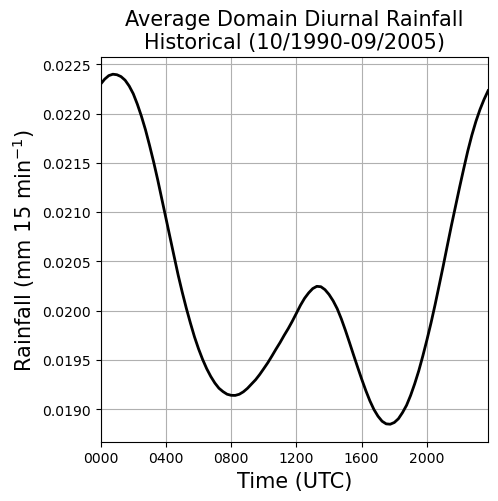

In [102]:
fig,axs=plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)

ax=axs
ax.plot(label_times,result.mean(dim=('south_north','west_east')),color='k',linewidth=2)
ax.set_ylabel('Rainfall (mm 15 min$^{-1}$)',fontsize=15)
ax.set_xlabel('Time (UTC)',fontsize=15)
ax.set_title('Average Domain Diurnal Rainfall\nHistorical (10/1990-09/2005)',fontsize=15)
ax.set_xlim(0,len(result)-1)
ax.set_xticks(np.arange(0,len(label_dates),16))
ax.grid()

plt.show()
plt.close()